# Installing the Yahoo finance library

In [ ]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 7.2MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=49a9b4efc27ee9f69f505176850175166b034a131d6f98d01e8af3ab23c5729a
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


# Importing the needed libraries

In [ ]:
import datetime
import pandas as pd
import numpy as np
import yfinance as yf 
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from keras.layers import Dropout, LSTM, Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Getting the historical S&P500 performance

In [ ]:
stock_ticker = '^GSPC'

In [ ]:
assets_prices_df = yf.download([stock_ticker], 
                               auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
assets_prices_df['Close'].head()

Date
1927-12-30    17.660000
1928-01-03    17.760000
1928-01-04    17.719999
1928-01-05    17.549999
1928-01-06    17.660000
Name: Close, dtype: float64

# Getting the Presidential Data

In [ ]:
presidential_data = pd.read_csv('presidential.csv')

In [ ]:
presidential_data

,name,start,end,party
0,Eisenhower,1953-01-20,1961-01-20,Republican
1,Kennedy,1961-01-20,1963-11-22,Democratic
2,Johnson,1963-11-22,1969-01-20,Democratic
3,Nixon,1969-01-20,1974-08-09,Republican
4,Ford,1974-08-09,1977-01-20,Republican
5,Carter,1977-01-20,1981-01-20,Democratic
6,Reagan I,1981-01-20,1985-01-20,Republican
7,Reagan II,1985-01-20,1989-01-20,Republican
8,Bush - Father,1989-01-20,1993-01-20,Republican
9,Clinton I,1993-01-20,1997-01-20,Democratic


# Formatting the datasets

In [ ]:
close_prices = assets_prices_df['Close']

In [ ]:
presidential_data['end'] = pd.to_datetime(presidential_data['end'])
presidential_data['start'] = pd.to_datetime(presidential_data['start'])

In [ ]:
def get_next_work_day(df, day):
    '''
    Function that receives the stock prices dataframe a date.
    If the date is a holliday or a weekend date it is returned the next
    work day.

    Parameters
    -------
    df: Pandas Dataframe
      A pandas dataframe that has a datetime index
    day: datetime
      A datetime day date.
    
    Return
    -------
    Datetime
      The next day that is at the df
    '''
    while day not in df:
        day += datetime.timedelta(days=1)
    return day

## Getting the percentual change of each legislation

In [ ]:

gains_list = list()
for index, row in presidential_data.iterrows():
    end = get_next_work_day(close_prices, row['end'])
    begin = get_next_work_day(close_prices, row['start'])
    
    gain = (close_prices[end] - close_prices[begin]) / close_prices[begin]
    gains_list.append(gain * 100)


In [ ]:
presidential_data['stocks_result'] = gains_list

# Plotting the results

## The stock performance in percentual at each legislation. The color of the bar indicates the party.

In [ ]:
def formatting_axis(ax, title, xlabel, ylabel):
  ax.axes.set_title(title, fontsize = 16, weight='bold')
  ax.set_xlabel(xlabel, fontsize = 10)
  ax.set_ylabel(ylabel, fontsize = 10)

In [ ]:
presidential_data

,name,start,end,party,stocks_result
0,Eisenhower,1953-01-20,1961-01-20,Republican,129.380262
1,Kennedy,1961-01-20,1963-11-22,Democratic,16.094065
2,Johnson,1963-11-22,1969-01-20,Democratic,46.085335
3,Nixon,1969-01-20,1974-08-09,Republican,-20.483825
4,Ford,1974-08-09,1977-01-20,Republican,27.343557
5,Carter,1977-01-20,1981-01-20,Democratic,27.852765
6,Reagan I,1981-01-20,1985-01-20,Republican,33.102927
7,Reagan II,1985-01-20,1989-01-20,Republican,63.573596
8,Bush - Father,1989-01-20,1993-01-20,Republican,51.194916
9,Clinton I,1993-01-20,1997-01-20,Democratic,79.223301


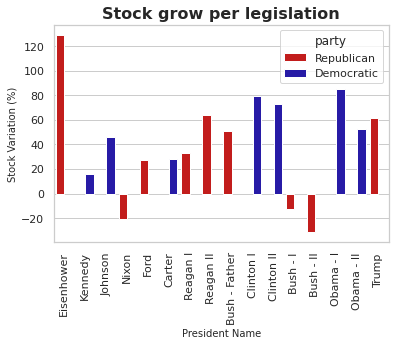

In [ ]:
palette ={'Democratic': '#1404BD', 'Republican': '#DE0100'}
sns.set_theme(style='whitegrid')
ax = sns.barplot(x='name', y='stocks_result', hue='party', data=presidential_data, palette=palette)
plt.setp(ax.get_xticklabels(), rotation=90)
formatting_axis(ax, 'Stock grow per legislation', 'President Name', 'Stock Variation (%)')
ax;

## Getting the average performance per year per party

In [ ]:
presidential_data['legislation_time_day'] = (presidential_data['end'] - presidential_data['start']).astype('timedelta64[D]')

In [ ]:
presidential_data_grouped = presidential_data.groupby(['party']).agg({'stocks_result':'sum', 'legislation_time_day': 'sum'}).reset_index()
presidential_data_grouped['legislation_time_year'] = presidential_data_grouped['legislation_time_day'] / 365.25
presidential_data_grouped['stock_grow_per_year'] = presidential_data_grouped['stocks_result'] / presidential_data_grouped['legislation_time_year']

## Ploting the average gain per year for each party

In [ ]:
presidential_data_grouped

,party,stocks_result,legislation_time_day,legislation_time_year,stock_grow_per_year
0,Democratic,379.689618,10227.0,28.000000,13.560343
1,Republican,301.681797,14561.0,39.865845,7.567425


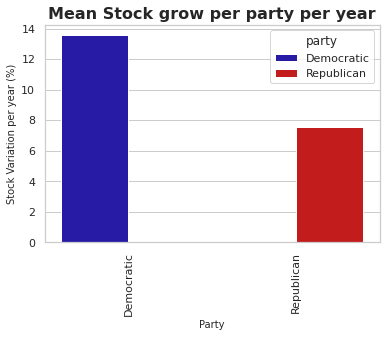

In [ ]:
palette ={'Democratic': '#1404BD', 'Republican': '#DE0100'}
sns.set_theme(style='whitegrid')
ax = sns.barplot(x='party', y='stock_grow_per_year', hue='party', data=presidential_data_grouped, palette=palette)
plt.setp(ax.get_xticklabels(), rotation=90)
formatting_axis(ax, 'Mean Stock grow per party per year', 'Party', 'Stock Variation per year (%)')
ax;

In [ ]:
def add_annotation(ax, name, data, date, i=0):
    '''
    Add an arrow annotation at the plot.
    '''
    ax.annotate(name,
                xy=(mdates.date2num(date), data['Close'][date]), xycoords='data',
                xytext=(i/30 + 0.4, i/30 + 0.45), textcoords='axes fraction',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='right', verticalalignment='top',
                weight='bold')

# Plotting the stock price performace at the pandemics date

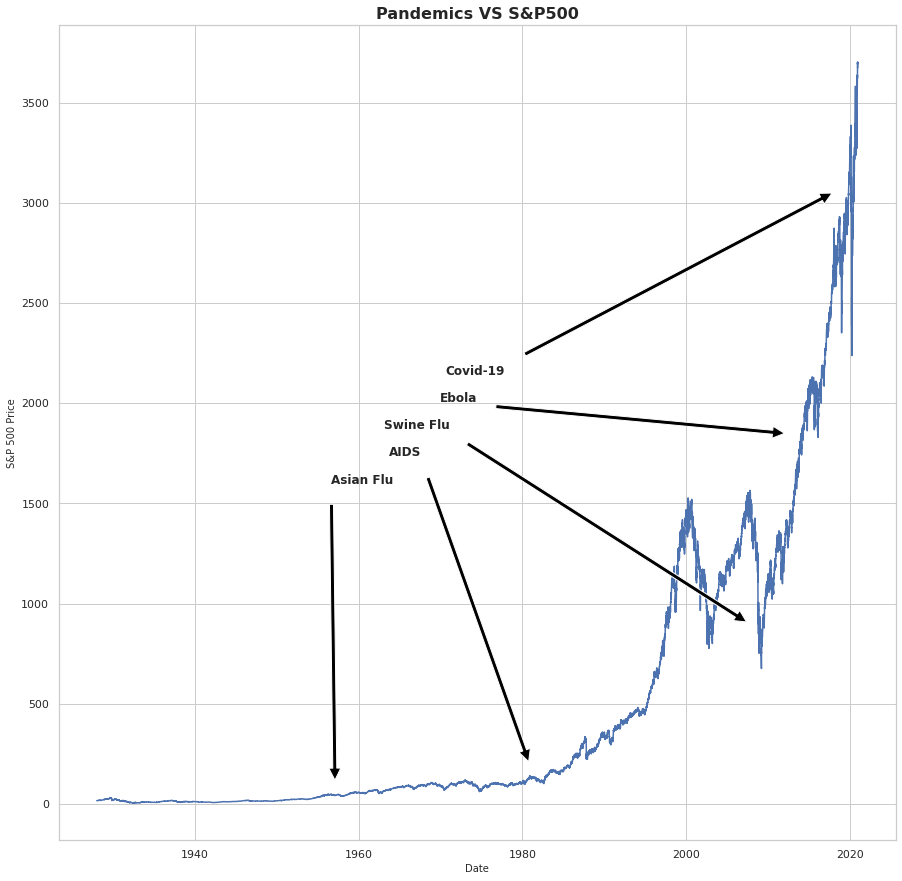

In [ ]:
# Create our figure and data we'll use for plotting
fig, ax = plt.subplots(figsize=(15, 15))

# Plot a line and add some simple annotations
line, = ax.plot(assets_prices_df.index, assets_prices_df['Close'])

asian_flu_date = datetime.datetime(1957, 2, 11)
asian_flu = 'Asian Flu'
aids_date = datetime.datetime(1981, 6, 10)
aids = 'AIDS'
swine_flu_date = datetime.datetime(2009, 4, 13)
swine_flu = 'Swine Flu'
ebola_date = datetime.datetime(2013, 12, 26)
ebola = 'Ebola'
covid_date = datetime.datetime(2019, 12, 3)
covid = 'Covid-19'
pandemic_dates = [asian_flu_date, aids_date, 
                  swine_flu_date, ebola_date, covid_date]
pandemic_names = [asian_flu, aids, swine_flu, ebola, covid]

for i, name in enumerate(pandemic_names):
    add_annotation(ax, name, assets_prices_df, pandemic_dates[i], i)
  
formatting_axis(ax, 'Pandemics VS S&P500', 'Date', 'S&P 500 Price')
plt.show();

## Plotting the stock performance at a range of one year before and after each one of the pandemics

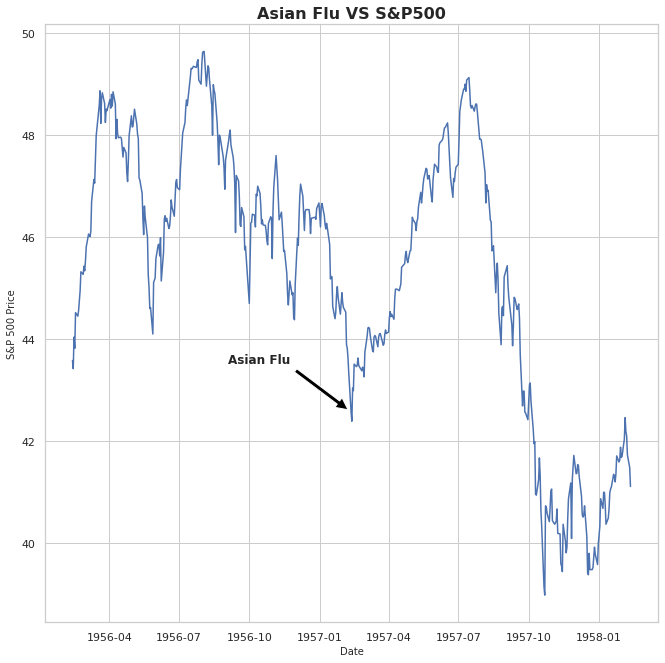

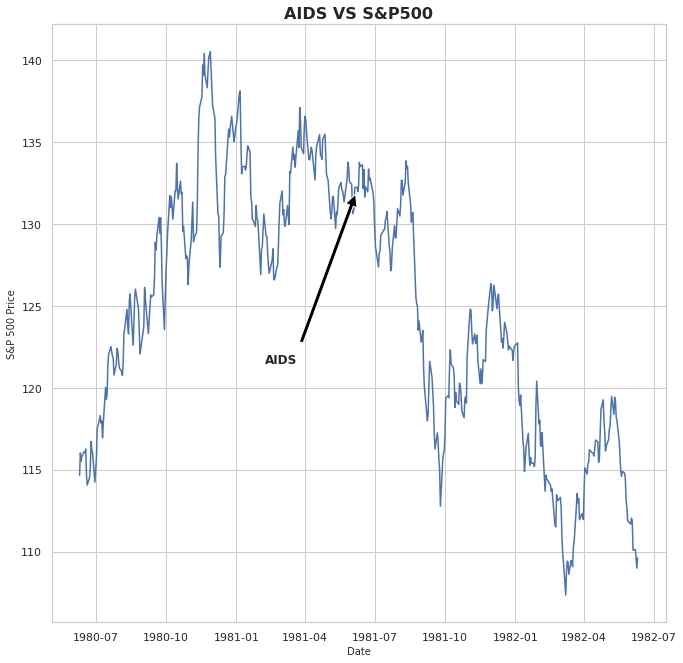

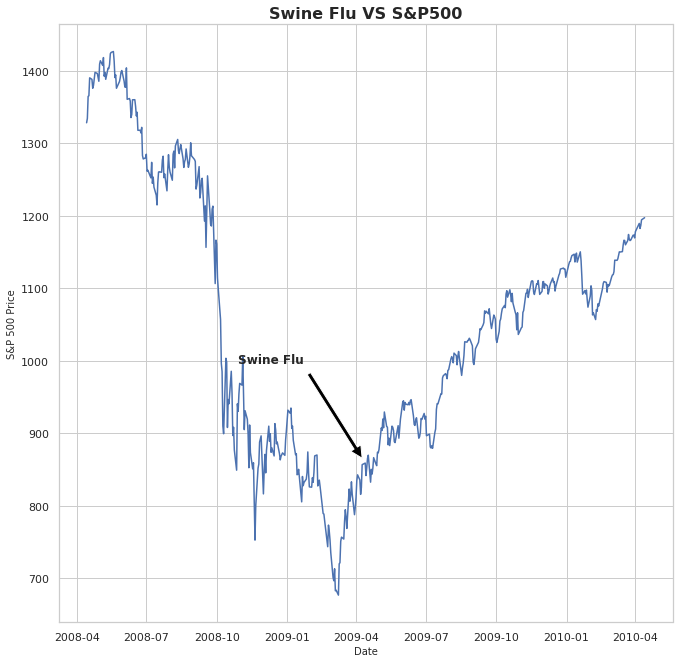

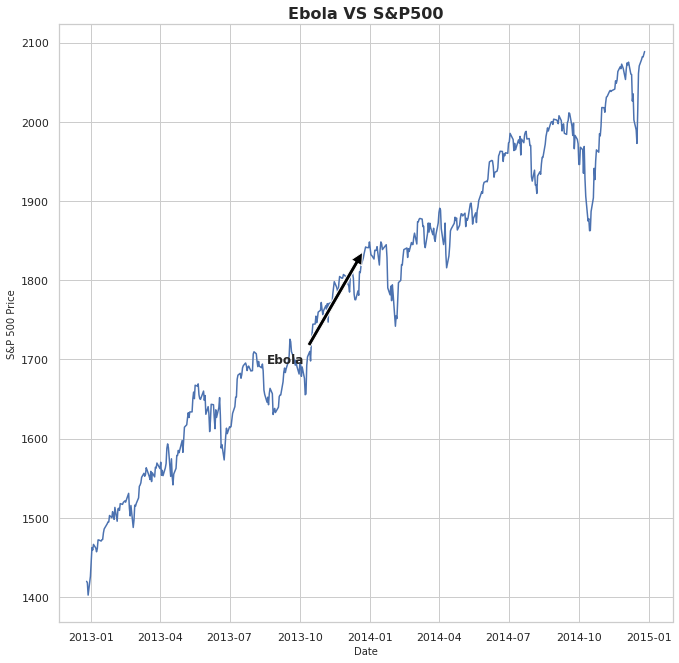

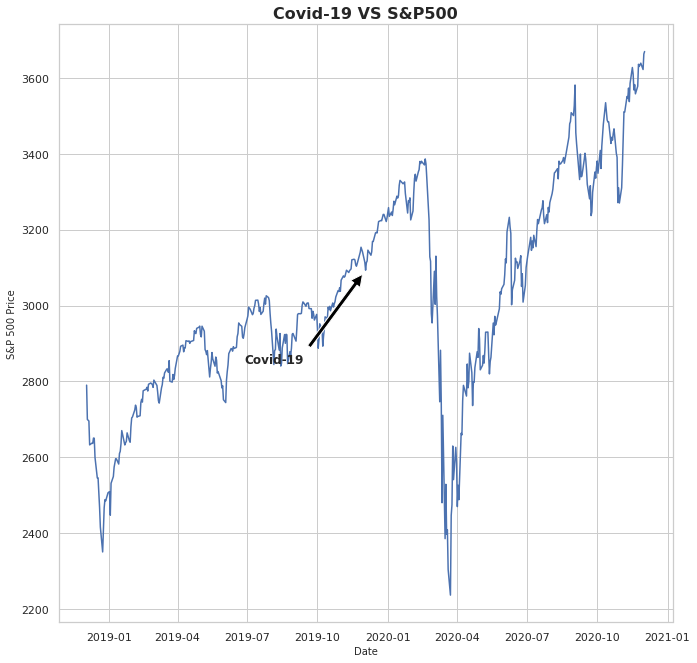

In [ ]:

pandemic_dates = [asian_flu_date, aids_date, 
                  swine_flu_date, ebola_date, covid_date]
pandemic_names = [asian_flu, aids, swine_flu, ebola, covid]

for i, date in enumerate(pandemic_dates):
    # Create our figure and data we'll use for plotting
    fig, ax = plt.subplots(figsize=(11, 11))

    # Plot a line and add some simple annotations
    # Adicionar programaticamente 1 ano pre pandemia e 1 ano pós pandemia

    assets_prices_df_pandemic= assets_prices_df[(date - datetime.timedelta(days=365)):(date + datetime.timedelta(days=365))]
    line, = ax.plot(assets_prices_df_pandemic.index, assets_prices_df_pandemic['Close'])
    add_annotation(ax, pandemic_names[i], assets_prices_df_pandemic, date)
    title = '{} VS S&P500'.format(pandemic_names[i])
    formatting_axis(ax, title, 'Date', 'S&P 500 Price')

# Formatting the data to use it on a LSTM neural network

In [ ]:
assets_prices_df.describe()

,Open,High,Low,Close,Volume
count,23347.000000,23347.000000,23347.000000,23347.000000,2.334700e+04
mean,490.028513,492.914430,486.955085,490.128231,7.736369e+08
std,732.668811,736.628904,728.352303,732.771211,1.490967e+09
min,4.400000,4.400000,4.400000,4.400000,0.000000e+00
25%,23.865001,23.865001,23.865001,23.865001,1.290000e+06
50%,99.580002,100.349998,98.790001,99.580002,1.741000e+07
75%,839.394989,849.865021,827.644989,839.884979,5.451050e+08
max,3705.979980,3712.389893,3678.879883,3702.250000,1.145623e+10


## Getting the close prices columns and scaling it

In [ ]:
scaler = MinMaxScaler()

In [ ]:
cols = assets_prices_df.columns.tolist()

In [ ]:
close_prices = assets_prices_df['Close'].values.reshape(assets_prices_df.shape[0],1)
close_prices = scaler.fit_transform(close_prices)
close_prices[:5]

array([[0.00358587],
       [0.00361291],
       [0.00360209],
       [0.00355612],
       [0.00358587]])

In [ ]:
look_back = 90
forward_days = 20
num_periods = 300

## Split the data in Train and Test

In [ ]:
division = len(close_prices) - num_periods*forward_days
close_prices_test = close_prices[division-look_back:]
close_prices_train = close_prices[:division]

In [ ]:
def processData(data, look_back, forward_days,jump=1):
    '''
    Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
    and `m` coming days as Y.
    '''
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [ ]:
X_test,y_test = processData(close_prices_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(close_prices_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(13790, 90, 1)
(3448, 90, 1)
(300, 90, 1)
(13790, 20)
(3448, 20)
(300, 20)


In [ ]:
X_train.shape

(13790, 90, 1)

# Building the LSTM model

In [ ]:
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 50

model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)

Epoch 1/50
6895/6895 - 52s - loss: 2.2001e-05 - val_loss: 2.1514e-06
Epoch 2/50
6895/6895 - 52s - loss: 6.9506e-06 - val_loss: 5.6847e-06
Epoch 3/50
6895/6895 - 52s - loss: 5.5372e-06 - val_loss: 5.2141e-05
Epoch 4/50
6895/6895 - 51s - loss: 5.1328e-06 - val_loss: 1.9111e-06
Epoch 5/50
6895/6895 - 52s - loss: 4.6338e-06 - val_loss: 2.3943e-06
Epoch 6/50
6895/6895 - 51s - loss: 3.7783e-06 - val_loss: 2.9685e-06
Epoch 7/50
6895/6895 - 51s - loss: 4.0629e-06 - val_loss: 1.7749e-06
Epoch 8/50
6895/6895 - 52s - loss: 3.4533e-06 - val_loss: 3.6954e-06
Epoch 9/50
6895/6895 - 52s - loss: 3.6343e-06 - val_loss: 1.5936e-05
Epoch 10/50
6895/6895 - 51s - loss: 3.3819e-06 - val_loss: 6.1259e-06
Epoch 11/50
6895/6895 - 51s - loss: 3.4003e-06 - val_loss: 2.2847e-06
Epoch 12/50
6895/6895 - 51s - loss: 3.1662e-06 - val_loss: 1.7455e-06
Epoch 13/50
6895/6895 - 51s - loss: 3.1319e-06 - val_loss: 2.2620e-06
Epoch 14/50
6895/6895 - 53s - loss: 3.2306e-06 - val_loss: 1.7464e-06
Epoch 15/50
6895/6895 - 52s -

## Plotting the Loss vs Validation Loss graph

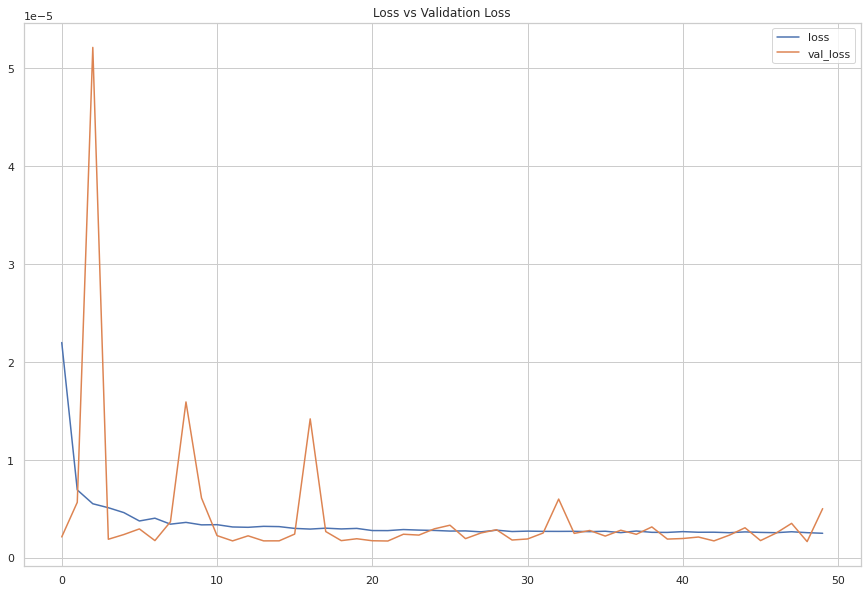

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.title('Loss vs Validation Loss')
plt.show()

## Plotting the predicted prices vs the real stock prices

In [ ]:
Xt = model.predict(X_test)

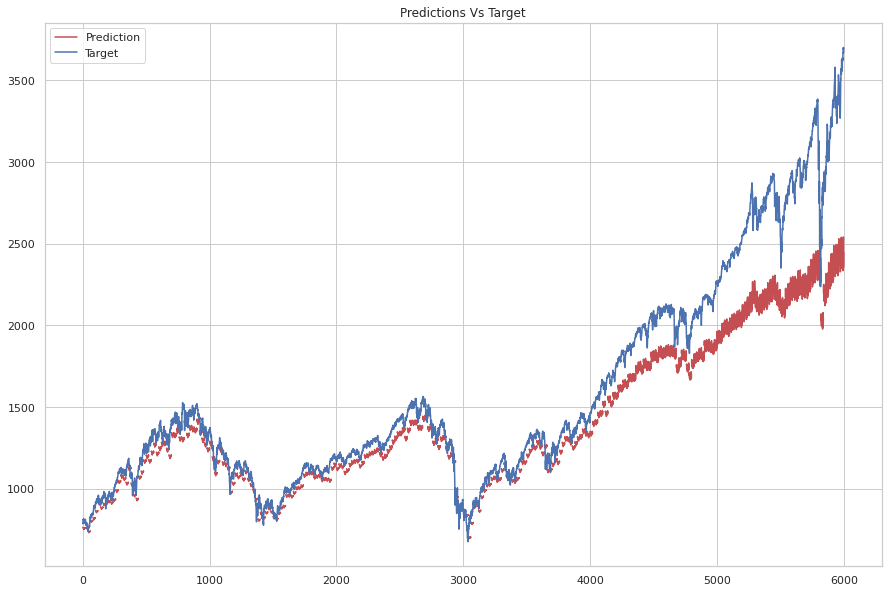

In [ ]:
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scaler.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scaler.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') #only to place the label
    
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.title('Predictions Vs Target')
plt.show()

## Predicting all the data to see how the model reacts to Train and Test set

In [ ]:
division = len(close_prices) - num_periods*forward_days

leftover = division%forward_days+1

array_test = close_prices[division-look_back:]
array_train = close_prices[leftover:division]

In [ ]:
Xtrain,ytrain = processData(array_train,look_back,forward_days,forward_days)
Xtest,ytest = processData(array_test,look_back,forward_days,forward_days)

In [ ]:
Xtrain = model.predict(Xtrain)
Xtrain = Xtrain.ravel()

Xtest = model.predict(Xtest)
Xtest = Xtest.ravel()

In [ ]:
y = np.concatenate((ytrain, ytest), axis=0)

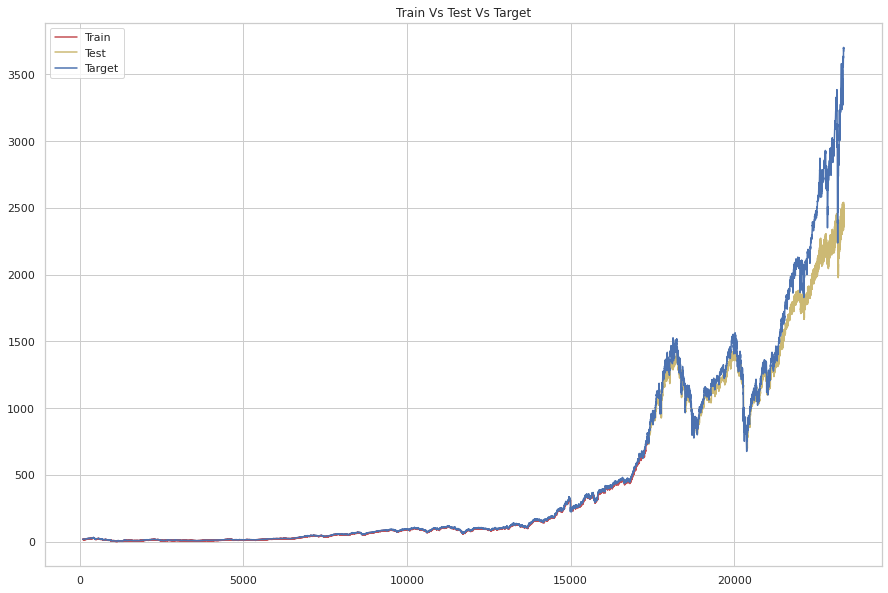

In [ ]:
plt.figure(figsize = (15,10))

# Data in Train/Validation
plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], scaler.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train')
# Data in Test
plt.plot([x for x in range(look_back +leftover+ len(Xtrain), len(Xtrain)+len(Xtest)+look_back+leftover)], scaler.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test')

#Data used
plt.plot([x for x in range(look_back+leftover, look_back+leftover+len(Xtrain)+len(Xtest))], scaler.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

plt.legend(loc='best')
plt.title('Train Vs Test Vs Target')
plt.show()